In [1]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from scipy.integrate import nquad, quad
from scipy.interpolate import interp1d
from scipy.special import erf, jn, jv, kn
import mpmath as mp
from skmonaco import mcimport, mcquad, mcmiser
import matplotlib.pylab as pylab
from cycler import cycler
import palettable

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
params = {'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['CMU Serif'],
          'font.sans-serif': ['CMU Sans Serif'],
          'legend.fontsize': 17,
          'legend.fancybox': True,
          'legend.frameon': False,
          'legend.framealpha': 0.4,
          'legend.labelspacing': 0.5,
          'figure.figsize': (6.4/1.1, 4.8/1.1),
          'axes.labelsize': 19,
          'axes.titlesize':18,
          'axes.titlepad':10,
          'axes.linewidth':1.1,
          'axes.labelpad':10,
          'axes.prop_cycle': cycler('color', palettable.cartocolors.qualitative.Bold_10.hex_colors) + 
                            cycler(alpha=10*[.7]), 
          'lines.linewidth':2.5,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 5,
          'xtick.minor.size': 2,
          'ytick.major.size': 5,
          'ytick.minor.size': 2,
          'xtick.major.width': 1,
          'ytick.major.width': 1,
          'xtick.minor.width': 0.8,
          'ytick.minor.width': 0.8,
         }
pylab.rcParams.update(params)

In [3]:
plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/draft/plots/"

In [4]:
alpha_plot = 0.8
lw_plot = 2.5
colors_plot = ['dodgerblue', 'orange', 'mediumorchid']

In [5]:
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

# Sensitivity to compact objects

In [6]:
def get_f_DM_lim(M_DM=1e8*M_s, R0_DM=0, sigma_mu = 1, sigma_alpha = None,
                 N_q_mu = 1e9, N_q_alpha = 1e9, 
                 l_min_mu=2, l_max_mu=2000, l_min_alpha=2, l_max_alpha=2, f_sky=1):
    
    l_max = max(l_max_mu, l_max_alpha)
    
    pspecpop = PowerSpectraPopulations(l_max=l_max)
    pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-3*kpc, R_max=260*kpc)
    pspecpop.set_mass_distribution_compact(M_DM=M_DM, f_DM=1,R0_DM=R0_DM)
        
    if sigma_mu is not None:
        Cl_ary = pspecpop.get_C_l_compact_total_ary()
    else:
        Cl_ary = np.zeros(len(Cl_ary)) 
    if sigma_alpha is not None:
        Cl_ary_accel = pspecpop.get_C_l_compact_total_ary(accel=True)
    else:
        Cl_ary_accel = np.zeros(len(Cl_ary)) 
            
    fDM_base = 0
    dfDM_base = 0.1
    

    Cl_ary_fid = np.array(Cl_ary)*fDM_base
    Cl_ary_accel_fid = np.array(Cl_ary_accel)*fDM_base

    p = np.array(Cl_ary)*(fDM_base + dfDM_base)
    m = np.array(Cl_ary)*(fDM_base - dfDM_base)

    p_a = np.array(Cl_ary_accel)*(fDM_base + dfDM_base)
    m_a = np.array(Cl_ary_accel)*(fDM_base - dfDM_base)

    fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                    p_a, m_a, l_min=1, l_max=l_max)

    parameters = [Cl_ary_fid, Cl_ary_accel_fid, 1, l_max, fDM]
    
    observation = AstrometryObservation(fsky=f_sky, sigma_mu=sigma_mu, sigma_alpha=sigma_alpha, 
                                        N_q_mu=N_q_mu, N_q_alpha=N_q_alpha, 
                                        l_min_mu=l_min_mu, l_max_mu=l_max_mu, l_min_alpha=l_min_alpha, l_max_alpha=l_max_alpha)
    
    
    
    fshr = FisherForecast(parameters, observation)
    lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
    return lim, fshr.fshr_l

In [7]:
def get_f_DM_lim_simple(M_DM=1e8*M_s, R0_DM=0, sigma=1,
                 N_q = 1e8,
                 l_min=2, l_max=2000, f_sky=1,
                 accel=False,
                 l_los_min=1e-3 * pc, l_los_max=10 * kpc):
        
    pspecpop = PowerSpectraPopulations(l_min=l_min, l_max=l_max)
    pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-3*kpc, R_max=260*kpc)
    pspecpop.set_mass_distribution_compact(M_DM=M_DM, f_DM=1,R0_DM=R0_DM)
        
    Cl_ary = np.nan_to_num(pspecpop.get_C_l_compact_total_ary(accel=accel, l_los_min=l_los_min, l_los_max=l_los_max))
    
    Nl_ary = np.array(len(pspecpop.l_ary) * [4 * np.pi * sigma ** 2 / N_q])
        
    F = f_sky * (pspecpop.l_ary + 0.5) * (Cl_ary / (Nl_ary)) ** 2
    
    lim = 1.64 * np.sqrt(1/np.sum(F))
        
    return lim, F

In [8]:
print(np.pi / np.sqrt(4 * np.pi / 1e8))
print(np.pi / np.sqrt(4 * np.pi / 1e12))
print(np.pi / np.sqrt(0.05 * 4 * np.pi / 1e11))

8862.26925452758
886226.925452758
1253314.1373155003


In [9]:
M_ary = np.logspace(-4.,9,100) * M_s
R_ary = np.logspace(-5,4.5,30) * pc

In [10]:
lim_ary = np.zeros((len(M_ary), len(R_ary)))
lim_ary_accel = np.zeros((len(M_ary), len(R_ary)))

In [11]:
M_baseline = 1e2 * M_s

In [13]:
for iR, R in enumerate(tqdm_notebook(R_ary)):
    lim_temp = get_f_DM_lim_simple(M_baseline, R0_DM=R, sigma=0.1, N_q=1e12, l_min=50, l_max=500000, accel=True,f_sky = 0.05,
                                  l_los_min=1e-3 * pc, l_los_max=1 * kpc)[0]
    for iM, M in enumerate(M_ary):
        lim_ary_accel[iM, iR] = M_baseline / M * lim_temp

../../theory/spec_calc.py:486: RuntimeWarning: divide by zero encountered in log10
  (self.l_ary_calc)]
/Users/smsharma/.conda/envs/Lensing-PowerSpectra/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [14]:
for iR, R in enumerate(tqdm_notebook(R_ary)):
    lim_temp = get_f_DM_lim_simple(M_baseline, R0_DM=R, sigma=1, N_q=1e8, l_min=10, l_max=5000, accel=False,
                                  l_los_min=1e-3 * pc, l_los_max=100 * kpc)[0]
    for iM, M in enumerate(M_ary):
        lim_ary[iM, iR] = M_baseline / M * lim_temp

../../theory/spec_calc.py:480: RuntimeWarning: divide by zero encountered in log10
  [self.C_l_compact_total(1, theta_deg_mask=theta_deg_mask, accel=True, l_los_min=l_los_min, l_los_max=l_los_max)])


In [15]:
lim_R = []
for iM, M in enumerate((M_ary)):
    lim_R.append(10 ** np.interp(0, np.log10(lim_ary[iM]), np.log10(R_ary)) / pc)

In [16]:
lim_R_accel = []
for iM, M in enumerate((M_ary)):
    lim_R_accel.append(10 ** np.interp(0, np.log10(lim_ary_accel[iM]), np.log10(R_ary)) / pc)

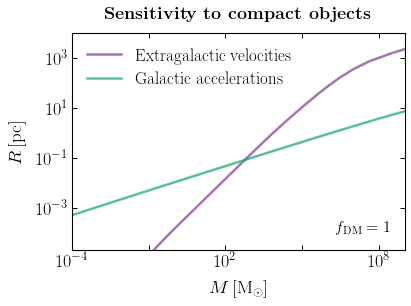

In [18]:
fig, ax = plt.subplots()

plt.plot(M_ary / M_s, np.array(lim_R), label="Extragalactic velocities")
plt.plot(M_ary / M_s, np.array(lim_R_accel), label="Galactic accelerations")

plt.xscale("log")
plt.yscale("log")

plt.xlim(np.min(M_ary / M_s),np.max(M_ary / M_s))
plt.ylim(2e-5,1e4)

plt.xlabel("$M$\,[M$_\odot$]")
plt.ylabel("$R$\,[pc]")

plt.title('\\textbf{Sensitivity to compact objects}', y = 1.02, fontsize=18)

plt.tight_layout()
plt.text(2e6, 1e-4, "$f_\mathrm{DM} = 1$", fontsize=16)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 1:
        label.set_visible(False)
        
plt.legend()

plt.tight_layout()
plt.savefig(plots_dir + "compact_M_vs_R.pdf")

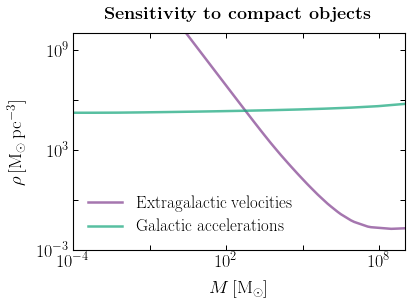

In [19]:
fig, ax = plt.subplots()

plt.plot(M_ary/M_s, M_ary / (4 / 3. * np.pi * (np.array(lim_R) * pc) ** 3) / (M_s / pc ** 3), label="Extragalactic velocities")
plt.plot(M_ary/M_s, M_ary / (4 / 3. * np.pi * (np.array(lim_R_accel) * pc) ** 3) / (M_s / pc ** 3), label="Galactic accelerations")
plt.xscale("log")
plt.yscale("log")

plt.xlim(np.min(M_ary / M_s),np.max(M_ary / M_s))
plt.ylim(1e-3, 1e10)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 1:
        label.set_visible(False)

for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 1:
        label.set_visible(False)

plt.title('\\textbf{Sensitivity to compact objects}', y = 1.02, fontsize=18)
plt.xlabel("$M$\,[M$_\odot$]")
plt.ylabel("$\\rho$\,[M$_\odot$\,pc$^{-3}$]")

plt.legend()

plt.tight_layout()
plt.savefig(plots_dir + "compact_M_vs_rho.pdf")